In [1]:
def add_src_and_logger(is_renkolab, save_dir):
    import sys
    from pathlib import Path
    import os
    import logging 
    src_path = Path.home() / "work" / "fco2diffusion" / "src"
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    if is_renkolab:
        DATA_PATH = '/home/jovyan/work/datapolybox/'
    else:
        DATA_PATH = '../data/training_data/'
    
    if (save_dir is not None) and (not os.path.exists(save_dir)):
        os.makedirs(save_dir)

    if save_dir is None:
        logging.basicConfig(
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    else:
        logging.basicConfig(
            filename=save_dir+'training.log',
            filemode='a',
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    return DATA_PATH, logging

is_renkolab = True
save_dir = None
DATA_PATH, logger = add_src_and_logger(is_renkolab, save_dir)

In [2]:
import pandas as pd
import numpy as np

dm = pd.read_parquet("./anoms.pq")
mlp = pd.read_parquet("./mlp_anoms.pq")

In [3]:
dm.columns

Index(['sst_anom', 'sss_anom', 'chl_anom', 'ssh_anom', 'mld_anom', 'sst_clim',
       'sss_clim', 'chl_clim', 'ssh_clim', 'mld_clim', 'xco2', 'co2_clim8d',
       'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat',
       'cos_lon_cos_lat', 'm_rotated', 'sample_0', 'sample_1', 'sample_2',
       'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8',
       'sample_9', 'sample_10', 'sample_11', 'sample_12', 'sample_13',
       'sample_14', 'sample_15', 'sample_16', 'sample_17', 'sample_18',
       'sample_19'],
      dtype='object')

In [4]:
mlp.columns

Index(['level_0', 'index', 'lat', 'lon', 'time', 'chl_globcolour',
       'chl_globcolour_uncert', 'chl_globcolour_flags', 'time_globcolour',
       'lat_globcolour', 'lon_globcolour', 'temp_soda', 'salt_soda',
       'mld_dens_soda', 'lon_soda', 'lat_soda', 'depth_soda', 'time_soda',
       'ssh_adt', 'ssh_sla', 'lat_cmems', 'lon_cmems', 'time_cmems', 'sss_cci',
       'sss_cci_random_error', 'lat_sss_cci', 'lon_sss_cci', 'time_sss_cci',
       'sss_multiobs', 'sss_multiobs_error', 'lat_sss_multiobs',
       'lon_sss_multiobs', 'depth_sss_multiobs', 'time_sss_multiobs',
       'sst_cci', 'sst_cci_uncertainty', 'ice_cci', 'time_sst_cci',
       'lat_sst_cci', 'lon_sst_cci', 'time_1d', 'day_of_year',
       'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat',
       'cos_lon_cos_lat', 'sin_lon', 'cos_lon', 'is_north', 'co2_clim8d',
       'xco2', 'seamask', 'chl_clim', 'chl_filled_clim', 'dayofyear_clim',
       'lat_clim', 'lon_clim', 'mld_clim', 'ssh_clim', 'sss_clim',


In [5]:
pred_cols = [f'sample_{i}' for i in range(20)]

# load model because did not rescale predictions
from fco2models.models import UNet2DModelWrapper, Unet2DClassifierFreeModel, UNet2DShipMix
from fco2models.ueval import load_model
save_path = '../models/anoms/'
model_path = 'e_200.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class,training_complete=True)
params['predictors']

There was a problem when trying to write in your cache folder (/home/jovyan/.cache/huggingface/hub). Please, ensure the directory exists and can be written to.


['sst_anom',
 'sss_anom',
 'chl_anom',
 'ssh_anom',
 'mld_anom',
 'sst_clim',
 'sss_clim',
 'chl_clim',
 'ssh_clim',
 'mld_clim',
 'xco2',
 'co2_clim8d',
 'sin_day_of_year',
 'cos_day_of_year',
 'sin_lat',
 'sin_lon_cos_lat',
 'cos_lon_cos_lat']

In [6]:
mlp['lon'] = np.round(mlp['lon']*4, 0) / 4  # Round to 0.25 degrees for coarsening
mlp['lat'] = np.round(mlp['lat']*4, 0) / 4  # Round to 0.25 degrees for coarsening

import healpy as hp
nside=1024
lon, lat = hp.pix2ang(nside, dm.index.values, nest=True, lonlat=True)
dm['lon'] = np.round(((lon + 180 ) % 360  - 180 )*4, 0) / 4  # Round to 0.25 degrees for coarsening
dm['lat'] = np.round(lat*4, 0) / 4  # Round to 0.25 degrees for coarsening

dm[pred_cols] = (dm[pred_cols] * params['train_stds'][0] + params['train_means'][0]) + (dm.xco2.values[:, np.newaxis] * params['train_stds'][11] + params['train_means'][11])
mlp[pred_cols] += mlp.xco2.values[:, np.newaxis]

2025-07-13 12:18:59,377 - WARNING - mkdir -p failed for path /home/jovyan/.cache/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.cache/matplotlib'
2025-07-13 12:18:59,379 - WARNING - Matplotlib created a temporary cache directory at /tmp/matplotlib-swm881dx because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2025-07-13 12:19:00,170 - INFO - generated new fontManager


In [7]:
mlp.columns

Index(['level_0', 'index', 'lat', 'lon', 'time', 'chl_globcolour',
       'chl_globcolour_uncert', 'chl_globcolour_flags', 'time_globcolour',
       'lat_globcolour', 'lon_globcolour', 'temp_soda', 'salt_soda',
       'mld_dens_soda', 'lon_soda', 'lat_soda', 'depth_soda', 'time_soda',
       'ssh_adt', 'ssh_sla', 'lat_cmems', 'lon_cmems', 'time_cmems', 'sss_cci',
       'sss_cci_random_error', 'lat_sss_cci', 'lon_sss_cci', 'time_sss_cci',
       'sss_multiobs', 'sss_multiobs_error', 'lat_sss_multiobs',
       'lon_sss_multiobs', 'depth_sss_multiobs', 'time_sss_multiobs',
       'sst_cci', 'sst_cci_uncertainty', 'ice_cci', 'time_sst_cci',
       'lat_sst_cci', 'lon_sst_cci', 'time_1d', 'day_of_year',
       'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat',
       'cos_lon_cos_lat', 'sin_lon', 'cos_lon', 'is_north', 'co2_clim8d',
       'xco2', 'seamask', 'chl_clim', 'chl_filled_clim', 'dayofyear_clim',
       'lat_clim', 'lon_clim', 'mld_clim', 'ssh_clim', 'sss_clim',


In [8]:
dm['mean_sample'] = dm[pred_cols].mean(axis=1)
dm['std_sample'] = dm[pred_cols].std(axis=1)
#mlp['predictions_mean'] += mlp.xco2

In [9]:
mlp_ds = mlp.groupby(['lat', 'lon']).mean().to_xarray()
dm_ds =  dm.groupby(['lat', 'lon']).mean().to_xarray()

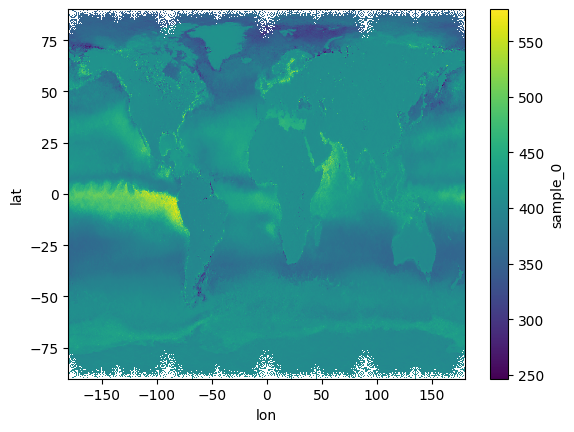

In [10]:
dm_ds.sample_0.plot()

In [11]:
import xarray as xr
masks = xr.open_dataset(DATA_PATH+"masks/RECCAP2_masks.nc")
masks2 = masks.reindex_like(dm_ds, method='nearest')
dm_ds = xr.merge([dm_ds, masks2])
#mlp_ds = xr.merge([mlp_ds, masks2])

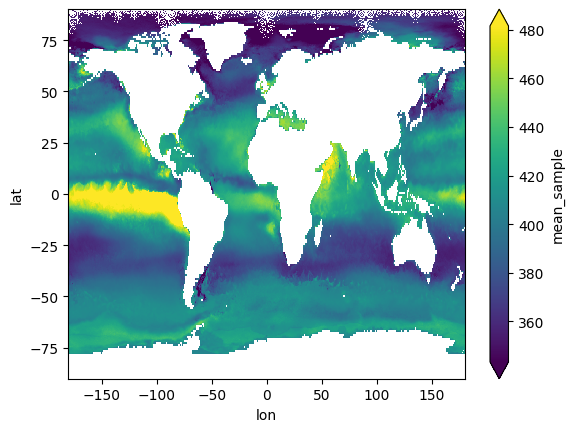

In [12]:
dm_ds.mean_sample.where(dm_ds.seamask==1).plot(robust=True)

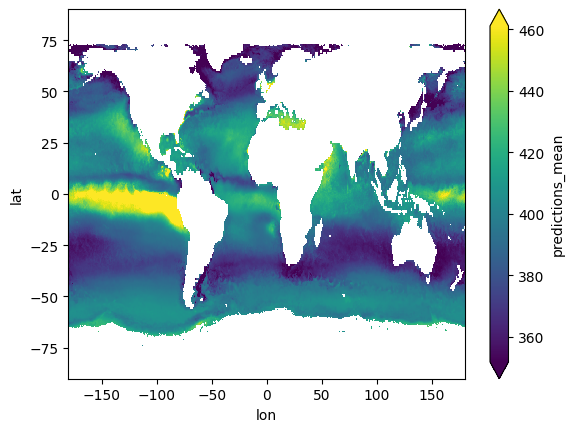

In [13]:
mlp_ds.predictions_mean.where(mlp_ds.seamask==1).plot(robust=True)

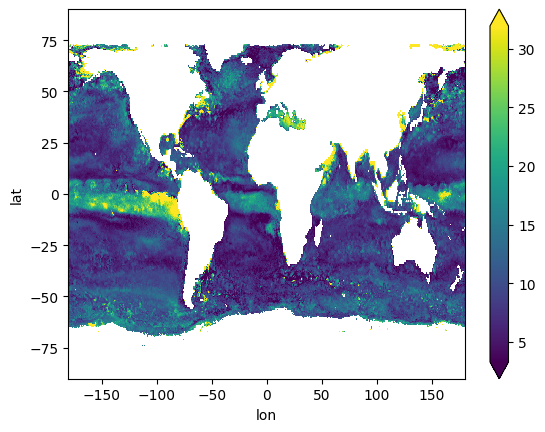

In [15]:
(mlp_ds.predictions_std - dm_ds.std_sample).where(dm_ds.seamask==1).plot(robust=True)

In [16]:
mlp_ds.predictions_std.mean()

<xarray.DataArray 'predictions_std' ()> Size: 8B
array(17.38054657)

In [17]:
dm_ds.std_sample.mean()

<xarray.DataArray 'std_sample' ()> Size: 8B
array(5.22543314)